# Targeting Direct Marketing with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background
Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers.  Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook presents an example problem to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls.  The steps include:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

### Note: This notebook has been upgraded to SageMaker API version 2, please upgrade to sagemaker version 2 using below pip command.
   `!pip install sagemaker --upgrade`

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# Import packages
import boto3
import re
import sagemaker        # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker import get_execution_role
sess=sagemaker.Session()
!pip install sagemaker --upgrade
print("SageMaker version is: "+sagemaker.__version__)
bucket= sess.default_bucket()
print(bucket)
prefix='sagemaker/DEMO-xgboost-dm-10202020'
role = get_execution_role()


Requirement already up-to-date: sagemaker in /opt/conda/lib/python3.7/site-packages (2.15.3)
SageMaker version is: 2.15.3
sagemaker-us-west-2-259649041186


Now let's bring in the Python libraries that we'll use throughout the analysis

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt # For charts and visualizations
import seaborn as sns
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
%matplotlib inline

---

## Data
Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket. 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [4]:
!apt-get update

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://security.debian.org/debian-security buster/updates InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Reading package lists... Done


In [5]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!apt-get install unzip -y
!unzip -o bank-additional.zip

--2020-10-22 18:33:18--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.213.33
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.213.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.009s  

2020-10-22 18:33:19 (48.1 MB/s) - ‘bank-additional.zip.1’ saved [432828/432828]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Archive:  bank-additional.zip
  inflating: bank-

Now lets read this into a Pandas data frame and take a look.

In [6]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [7]:
# Copy the data so that we can look into original data when required
data_copy=data.copy()
data_copy.shape

(41188, 21)

### Exploration
We have looked into the Exploration part in the feature engineering lab on Week 2 - Day 1

### Transformation

We have looked into the Exploration part in the feature engineering lab on Week 2 - Day 1.
We will only go through what is absolutely needed for this dataset and XGBoost algorithm

In [8]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
print(data.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  \
0           1.1          9

### Optional Cell

In [9]:
#Can you find a way to do above just using pandas without numpy?
data_copy['no_previous_contact']=data_copy.pdays.apply(lambda days: 1 if days == 999 else 0 )
data_copy

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,1
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,1
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1


In [10]:
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators

Another question to ask yourself before building a model is whether certain features will add value in your final use case.  For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction?  Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather.  So, including this in your model may give you a false sense of precision.

Following this logic, let's remove the economic features and `duration` from our data as they would need to be forecasted with high precision to use as inputs in future predictions.

Even if we were to use values of the economic indicators from the previous quarter, this value is likely not as relevant for prospects contacted early in the next quarter as those contacted later on.

In [11]:
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [12]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [13]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [15]:
data.corr().style.background_gradient(cmap ='Greens').set_properties(**{'font-size': '10px'})

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,-0.034292,0.207547
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,-0.047634,0.013182
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,0.052569,-0.017529
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,0.999992,-0.112797
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,-0.587462,0.104066
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,0.270945,-0.155341
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,0.078715,-0.070433
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,-0.091254,0.076003
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,0.296920,-0.155501
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,0.372682,-0.187766


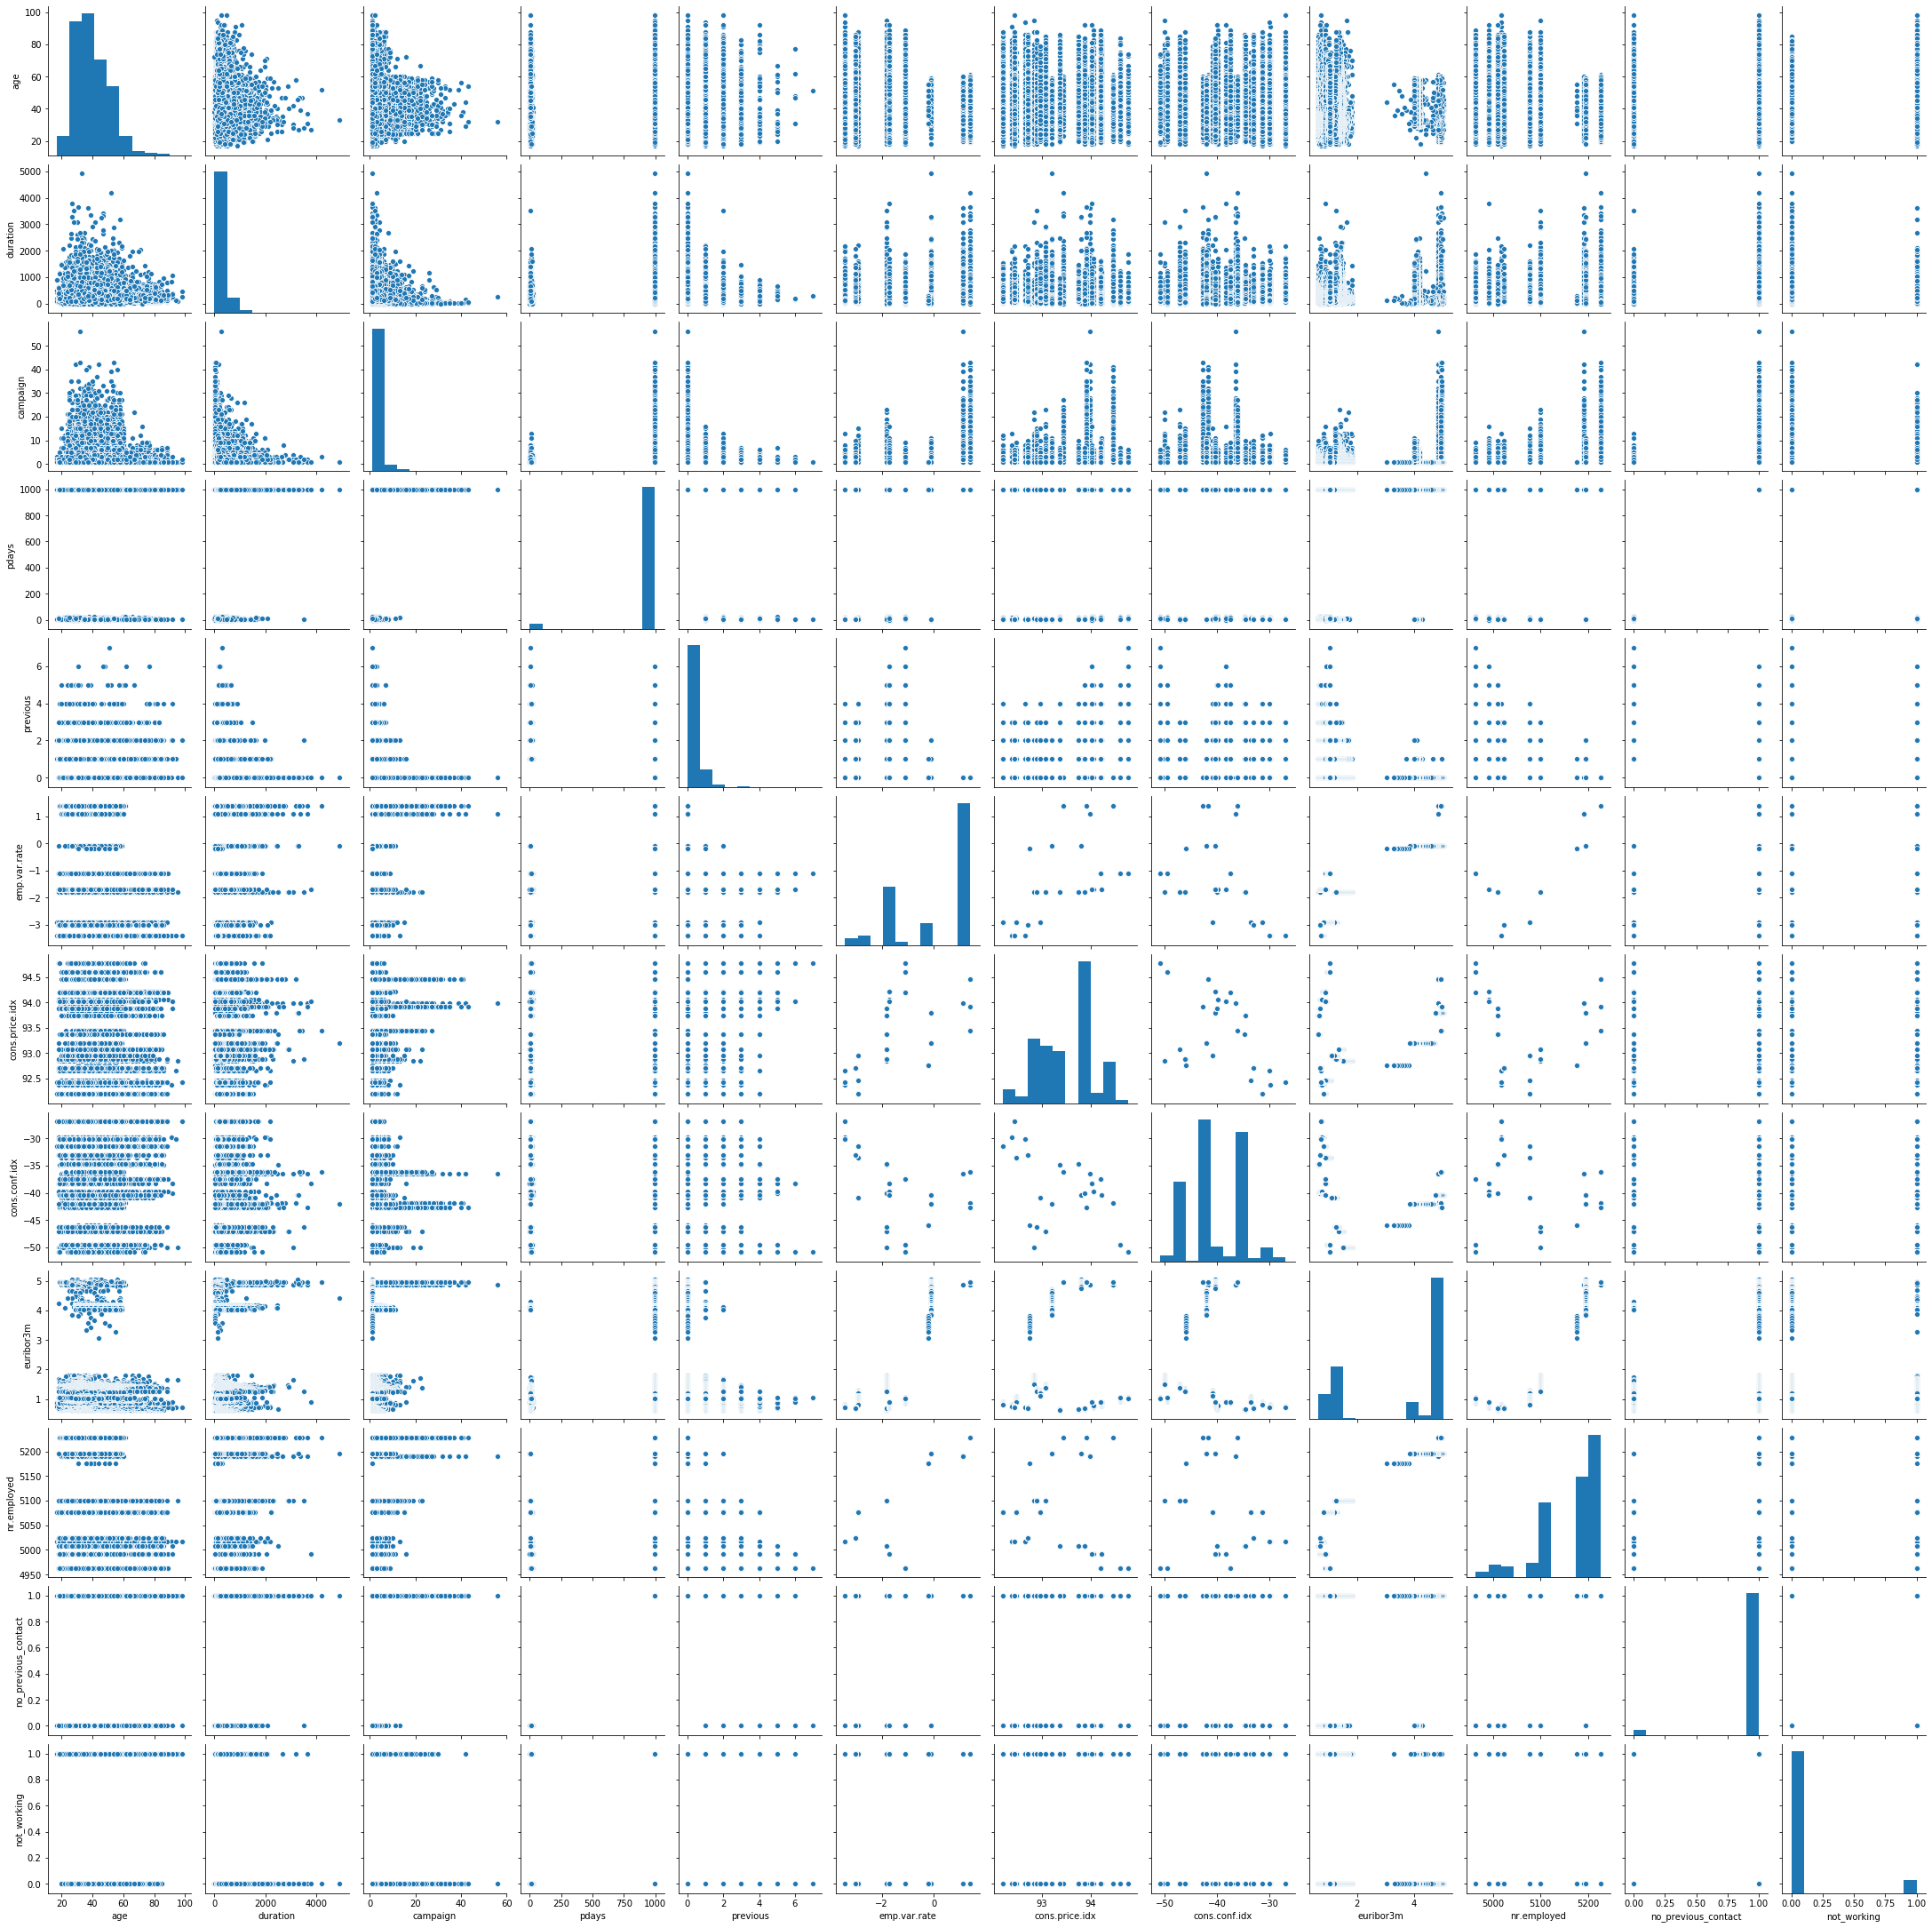

In [16]:
sns.pairplot(data)

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

[xgboost](https://xgboost.readthedocs.io/en/release_0.90/tutorials/model.html) is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [17]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [18]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [19]:
sagemaker.estimator.Estimator??

Init signature:
sagemaker.estimator.Estimator(
    image_uri,
    role,
    instance_count=None,
    instance_type=None,
    volume_size=30,
    volume_kms_key=None,
    max_run=86400,
    input_mode='File',
    output_path=None,
    output_kms_key=None,
    base_job_name=None,
    sagemaker_session=None,
    hyperparameters=None,
    tags=None,
    subnets=None,
    security_group_ids=None,
    model_uri=None,
    model_channel_name='model',
    metric_definitions=None,
    encrypt_inter_container_traffic=False,
    use_spot_instances=False,
    max_wait=None,
    checkpoint_s3_uri=None,
    checkpoint_local_path=None,
    enable_network_isolation=False,
    rules=None,
    debugger_hook_config=None,
    tensorboard_output_config=None,
    enable_sagemaker_metrics=None,
    **kwargs,
)
Source:        
class Estimator(EstimatorBase):
    """A generic Estimator to train using any supplied algorithm. This class is
    designed for use with algorithms that don't have their own, custom cla

In [20]:
print("Training Start time is: "+strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)


xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 


Training Start time is: 2020-10-22-18-35-33
2020-10-22 18:35:34 Starting - Starting the training job...
2020-10-22 18:35:36 Starting - Launching requested ML instances......
2020-10-22 18:37:01 Starting - Preparing the instances for training......
2020-10-22 18:37:51 Downloading - Downloading input data...
2020-10-22 18:38:32 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
IN

### Options to be aware of for better training 
    1. Using single instance (Horovod)/multiple instances for parallel training (Parameter Server) 
    2. Distributing the data across nodes using S3 key based sharding or use the data in fully replicated mode.
    3. Streaming mode or pipe mode for faster training
    4. Sagemaker Local Mode for training on the notebook instance itself.
    5. Use Managed Spot for saving costs
#### Refer to the parameters passed to the [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/algorithm.html) to understand various options.

### Optional Start
Train the model in pipe mode/with multiple instance, can you try fully distributed mode vs S3 sharding?, do you see any increase in the traning speed? does the model overfit with increased depth of a tree? 

In [24]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv', distribution='ShardedByS3Key')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv', distribution='ShardedByS3Key')

In [25]:
# #Cell for implementing above Optional task

print("Training Start time is: "+strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=2, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    input_mode='Pipe',
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)


xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 


Training Start time is: 2020-10-22-18-51-24
2020-10-22 18:51:24 Starting - Starting the training job...
2020-10-22 18:51:26 Starting - Launching requested ML instances......
2020-10-22 18:52:36 Starting - Preparing the instances for training...
2020-10-22 18:53:21 Downloading - Downloading input data...
2020-10-22 18:53:51 Training - Downloading the training image...
2020-10-22 18:54:24 Uploading - Uploading generated training model
2020-10-22 18:54:24 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Pipe path /opt/ml/input/data/train found.
INFO:root:Pipe path /opt/ml/input/data/validation found.
INFO:root:Distributed node traini

### Optional End

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [26]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

-----------!

### Optional start

### How to deploy the model with custom config such as diff traffic for each model and enabling autoscaling of the model? 
Refer to [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-deploy-model.html) for more details 
 
 Steps:
        
        1. Pass a training job name to xgb.fit function above
        
        2. use sagemaker.describe_training_job to get the model artifacts
        
        3. create a model using sagemaker.create_model
        
        4. Use below cell to create endpoint and endpoint config.

In [27]:
training_job_name1 = "sagemaker-xgboost-2020-10-22-18-51-24-113"
training_job_name2 = "sagemaker-xgboost-2020-10-22-18-35-33-881"

In [36]:
import boto3
sm = boto3.client('sagemaker')

#Creating new model based off other trainin job
model_name_1 = training_job_name1 + '-mod'

#hard coding model from above xgboost deployment
model_name_2 = "sagemaker-xgboost-2020-10-22-18-58-03-287"
info1 = sm.describe_training_job(TrainingJobName=training_job_name1)
model_data1 = info1['ModelArtifacts']['S3ModelArtifacts']
print(model_data1)

model1 = {
    'Image' : container,
    'ModelDataUrl' : model_data1
}

create_model_response = sm.create_model(
    ModelName = model_name_1,
    ExecutionRoleArn = role,
    PrimaryContainer = model1
)
print(create_model_response['ModelArn'])


s3://sagemaker-us-west-2-259649041186/sagemaker/DEMO-xgboost-dm-10202020/output/sagemaker-xgboost-2020-10-22-18-51-24-113/output/model.tar.gz
arn:aws:sagemaker:us-west-2:259649041186:model/sagemaker-xgboost-2020-10-22-18-51-24-113-mod


In [43]:
#set endpoint name/config.
endpoint_config_name = 'DEMO-model-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = 'DEMO-model-config-'  + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [44]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':25,
        'InitialInstanceCount':1,
        'ModelName':model_name_2,
        'VariantName':'Model2'},
        {
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':75,
        'InitialInstanceCount':1,
        'ModelName':model_name_1,
        'VariantName':'Model1'}
        
    ]

)

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])


create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:259649041186:endpoint-config/demo-model-config-2020-10-22-19-33-14
arn:aws:sagemaker:us-west-2:259649041186:endpoint/demo-model-config-2020-10-22-19-33-14
Status: Creating


In [45]:
%%time
import time
status = resp['EndpointStatus']
while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:259649041186:endpoint/demo-model-config-2020-10-22-19-33-14
Status: InService
CPU times: user 87 ms, sys: 20.1 ms, total: 107 ms
Wall time: 8min 1s


### Please perform below tasks as homework

1. Create endpoint with autoscaling
2. Create an end point with two models where first model gets 75% of the traffic and other model gets 25% of the traffic.


In [48]:
pip install awscli

Note: you may need to restart the kernel to use updated packages.


In [52]:
# Register model with Application AutoScaling:
aa = boto3.client('application-autoscaling')
response = aa.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-model-config-2020-10-22-19-33-14/variant/Model1',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=2,
    #RoleARN=role,
)

In [59]:
aa = boto3.client('application-autoscaling')
response = aa.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-model-config-2020-10-22-19-33-14/variant/Model2',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=2,
    #RoleARN=role,
)

In [56]:
response = aa.put_scaling_policy(
    PolicyName='TestScaling',
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-model-config-2020-10-22-19-33-14/variant/Model1',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 70,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',
        },
        'ScaleOutCooldown': 300,
        'ScaleInCooldown': 600
    }
    
)

In [60]:
response = aa.put_scaling_policy(
    PolicyName='TestScaling',
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-model-config-2020-10-22-19-33-14/variant/Model2',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 70,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',
        },
        'ScaleOutCooldown': 300,
        'ScaleInCooldown': 600
    }
    
)

### Optional end

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [61]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [65]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy())
predictions

array([0.03594091, 0.12638026, 0.20604549, ..., 0.04015449, 0.02302186,
       0.036677  ])

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [63]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3587,49
1,387,96


So, of the ~4000 potential customers, we predicted 136 would subscribe and 94 of them actually did.  We also had 389 subscribers who subscribed that we did not predict would.  This is less than desirable, but the model can (and should) be tuned to improve this.  Most importantly, note that with minimal effort, our model produced accuracies similar to those published [here](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf).

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above._

### Optional section for evaluation

1. Deploy above model with [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)

In [80]:
#pd.concat(test_data.drop(['y_no', 'y_yes'], axis=1), axis=1).to_csv('test_data.csv', index=False, header=False)
test_data.drop(['y_no', 'y_yes'], axis=1).to_csv('test_data.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test_data.csv')

In [81]:
batch_input = 's3://{}/{}/test/test.csv' .format(bucket,prefix)

batch_output = 's3://{}/{}/output/batch-inference' .format(bucket,prefix)

transformer = sagemaker.transformer.Transformer(model_name_1, instance_count=1, instance_type='ml.m5.xlarge', output_path=batch_output)
transformer.transform(data=batch_input, data_type='S3Prefix',content_type='text/csv', split_type='Line')
transformer.wait()


.............................[2020-10-22:20:23:51:INFO] No GPUs detected (normal if no gpus installed)
[2020-10-22:20:23:51:INFO] No GPUs detected (normal if no gpus installed)
[2020-10-22:20:23:51:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


2020/10/22 20:23:51 [crit] 19#19: *1 connect

### Parameters vs Hyperparamters?

## Automatic model Tuning 
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.
For example, suppose that you want to solve a binary classification problem on this marketing dataset. Your goal is to maximize the area under the curve (auc) metric of the algorithm by training an XGBoost Algorithm model. You don't know which values of the eta, alpha, min_child_weight, and max_depth hyperparameters to use to train the best model. To find the best values for these hyperparameters, you can specify ranges of values that Amazon SageMaker hyperparameter tuning searches to find the combination of values that results in the training job that performs the best as measured by the objective metric that you chose. Hyperparameter tuning launches training jobs that use hyperparameter values in the ranges that you specified, and returns the training job with highest auc.


In [82]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [83]:
objective_metric_name = 'validation:auc'

In [84]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)


In [85]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False,wait=False)

In [89]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

### Challenge
#### what is the hyper parameter tuning strategy used above

In [87]:
tuner.strategy

'Bayesian'

### Challenge
#### What are two different Hyper Paramter tuning strategies that Sagemaker provides?
#### What can you do to leverage the results of an existing tuning job for further tuning jobs when 1. Identical data and Algorithm 2. Transfer Learning?
### Optional Section Start

Answer: Two different hyperparemeter strategies are Random, Automatic Scaling, Warping?
Answer: Use a Warm Start Tuning Job with IDENTICAL_DATA_AND_ALGORITHM or TRANSFER_LEARNING

In [92]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3,
                            strategy='Random')

In [93]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False,wait=False)

### Optional section end

### Hyperparameter Optimisation 

Common methods are

1. Naive Grid Search
    --> Learning Rate and Number of Layers --> hard to scale as the data dimentionality increases.
2. Random Search (Sampling Random Combinations) --> Searche for best paramters randomly, better than Naive Grid Search if effect of some of the hyper parameters not much--> 
3. Bayesian Optimization --> Uses ML to simulate and find hyper paramters --> Looks into previous results to find the regions to explore for best hyperparameters --> Less compute intensive than trying to train on a larget dataset and on a big neural network 

---

## Extensions

This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems.  In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning.  In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain customer information not available in our initial dataset.

### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [94]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)